# Datamart para el análisis

Hacemos la calidad de datos antes de juntar las tablas y crear el tablon analitico. En este caso los datos no son masivos pero es buena práctica hacer primero la calidad de datos individual de cada tabla, sobre todo porque si  el volumen fuera muy alto al unirlos todavía se multiplica más.

Por tanto inicialmente las dejaramos como tablas individuales, después aplicaremos calidad de datos y finalmente las uniremos para forma el tablón o más oficialmente el datamart analítico.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#Automcompletar rápido
%config IPCompleter.greedy=True

import sqlalchemy as sa

## Importacion de datos

### Importacion de datos internos

In [2]:
con= sa.create_engine("sqlite:///Datos2023/airbnb.db")

In [3]:
from sqlalchemy import inspect

ins = inspect(con)
tablas = ins.get_table_names()
tablas

['df', 'df_analisis', 'listings', 'listings_det']

In [4]:
for tabla in tablas: 
    exec(f'{tabla} = pd.read_sql(tabla, con)')


**Dimension de todas las tablas importadas**

In [5]:
for cada in tablas: 
    print(cada + ": " + str(eval(cada).shape))

df: (21387, 23)
df_analisis: (21319, 34)
listings: (25543, 19)
listings_det: (25543, 76)


### Importacion de datos externos

En nuestros datos no tenemos el precio de compra de un inmueble, pero es una de las palancas principales del proyecto. 

Por tanto vasos a buscar esos datos de forma externa.

En esta página tenemos justo la info que necesitamos: https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/

Extraemos la información con el plugin instant data scraper de Chrome, y la guardamos en nuestra carpeta de Datos con el nombre 'precios_idealista.csv'

In [6]:
precio_m2 = (pd.read_csv("Datos2023/idealista2024.csv")
 .loc[1: , ["icon-elbow", "table__cell 2"]]
 .rename(columns = {"icon-elbow":"distrito","table__cell 2":"precio_m2"})
)
precio_m2

,distrito,precio_m2
1,Arganzuela,4.595 €/m2
2,Barajas,3.549 €/m2
3,Carabanchel,2.612 €/m2
4,Centro,6.144 €/m2
5,Chamartín,6.039 €/m2
6,Chamberí,6.347 €/m2
7,Ciudad Lineal,3.497 €/m2
8,Fuencarral,3.909 €/m2
9,Hortaleza,4.133 €/m2
10,Latina,2.699 €/m2


In [7]:
precio_m2.dtypes

distrito     object
precio_m2    object
dtype: object

In [8]:
precio_m2["precio_m2"] = precio_m2.precio_m2.str.removesuffix(" €/m2").str.replace(".", "").astype("int")

In [9]:
precio_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 1 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   distrito   21 non-null     object
 1   precio_m2  21 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 384.0+ bytes


In [10]:
precio_m2.sort_values(by="precio_m2",ascending=False)

,distrito,precio_m2
15,Salamanca,7374
6,Chamberí,6347
4,Centro,6144
5,Chamartín,6039
14,Retiro,5447
11,Moncloa,4700
1,Arganzuela,4595
17,Tetuán,4344
9,Hortaleza,4133
8,Fuencarral,3909


## Calidad de datos

En primer lugar haremos la calidad de datos individual de cada tabla, y finalmente las uniremos para forma el tablón analítico.

### Tabla Listings

In [11]:
listings.head(5)

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,85.0,5,106,2023-10-16,0.63,1,22,4,None
1,1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Dana,Centro,Sol,40.41476,-3.70418,Entire home/apt,65.0,5,172,2022-09-26,1.05,3,0,0,None
2,2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,33,2018-07-15,0.30,2,135,0,None
3,3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Alvaro,Centro,Universidad,40.42183,-3.70529,Entire home/apt,94.0,5,33,2023-11-06,0.30,1,168,8,None
4,4,30959,Loft in Madrid · ★4.38 · 1 bedroom · 1 bed · 1...,132883,Angela,Centro,Embajadores,40.41259,-3.70105,Entire home/apt,NaN,3,8,2017-05-30,0.08,1,0,0,None


In [12]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           25543 non-null  int64  
 1   id                              25543 non-null  int64  
 2   name                            25543 non-null  object 
 3   host_id                         25543 non-null  int64  
 4   host_name                       25532 non-null  object 
 5   neighbourhood_group             25543 non-null  object 
 6   neighbourhood                   25543 non-null  object 
 7   latitude                        25543 non-null  float64
 8   longitude                       25543 non-null  float64
 9   room_type                       25543 non-null  object 
 10  price                           21734 non-null  float64
 11  minimum_nights                  25543 non-null  int64  
 12  number_of_reviews               

#### Variables y data types

- Nos quedamos con las variables que nos interesan en nuestro caso. 

In [13]:
listings = listings[['id', 'name', 'host_id', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'calculated_host_listings_count',
       'availability_365']]
listings.head(5)

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,85.0,5,1,22
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.41476,-3.70418,Entire home/apt,65.0,5,3,0
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,2,135
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,94.0,5,1,168
4,30959,Loft in Madrid · ★4.38 · 1 bedroom · 1 bed · 1...,132883,Centro,Embajadores,40.41259,-3.70105,Entire home/apt,NaN,3,1,0


#### Creacion de nuevas variables 

- La variable 'name' contiene una descripción detallada de la vivienda, incluyendo el número de habitaciones y baños. Utilizaremos esta información para crear nuevas variables relevantes para nuestro análisis

##### Bedrooms

In [14]:
def extract_bedrooms(name):
    words = name.split()
    try:
        index = words.index("bedrooms" if "bedrooms" in words else "bedroom") - 1
        return int(words[index]) if index >= 0 else None
    except ValueError:
        return None


In [15]:
listings["bedrooms"] = listings["name"].apply(extract_bedrooms)


##### Bathrooms

In [16]:
def extract_bathrooms(name):
    words = name.split()
    try:
        for i, word in enumerate(words):
            if word in ["private", "shared", "bath", "baths", "Half-bath"]:
                if words[i-1].replace('.', '').isdigit():  # Check if previous word is a number
                    return float(words[i-1])  # Convert to float if it's a decimal
                elif words[i-1].isdigit():  # Check if previous word is a number
                    return int(words[i-1])  # Convert to int if it's an integer
        return None
    except IndexError:
        return None


In [17]:
listings["bathrooms"] = listings["name"].apply(extract_bathrooms)

- Revisamos los tipos de las variables

In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25543 non-null  int64  
 1   name                            25543 non-null  object 
 2   host_id                         25543 non-null  int64  
 3   neighbourhood_group             25543 non-null  object 
 4   neighbourhood                   25543 non-null  object 
 5   latitude                        25543 non-null  float64
 6   longitude                       25543 non-null  float64
 7   room_type                       25543 non-null  object 
 8   price                           21734 non-null  float64
 9   minimum_nights                  25543 non-null  int64  
 10  calculated_host_listings_count  25543 non-null  int64  
 11  availability_365                25543 non-null  int64  
 12  bedrooms                        

In [19]:
for elem in ["neighbourhood_group","neighbourhood", "room_type"]:
    listings[elem] = listings[elem].astype("category")

In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              25543 non-null  int64   
 1   name                            25543 non-null  object  
 2   host_id                         25543 non-null  int64   
 3   neighbourhood_group             25543 non-null  category
 4   neighbourhood                   25543 non-null  category
 5   latitude                        25543 non-null  float64 
 6   longitude                       25543 non-null  float64 
 7   room_type                       25543 non-null  category
 8   price                           21734 non-null  float64 
 9   minimum_nights                  25543 non-null  int64   
 10  calculated_host_listings_count  25543 non-null  int64   
 11  availability_365                25543 non-null  int64   
 12  bedrooms          

#### Analisis de nulos

In [21]:
listings.isna().sum()

id                                   0
name                                 0
host_id                              0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                             3809
minimum_nights                       0
calculated_host_listings_count       0
availability_365                     0
bedrooms                          1747
bathrooms                          197
dtype: int64

**Nulos en el precio**

In [22]:
listings.dropna(subset="price", inplace=True)

**Nulos en bedrooms**


In [23]:
listings.loc[listings.bedrooms.isna()].shape

(1505, 14)

- Observamos que la mayoría de los valores nulos en la variable 'bedrooms' corresponden a inmuebles de tipo 'Studio', como indica la variable 'name'. 
- Por lo tanto, vamos a actualizar el tipo de habitación ('room_type') a 'Studio' para todos los inmuebles cuyo nombre contenga la palabra 'Studio'. 
- Por último a los Studios les asignamos 1 habitación. 

In [24]:
listings.name.str.contains("Studio").value_counts()

name
False    20244
True      1490
Name: count, dtype: int64

In [25]:
existing_categories = listings['room_type'].unique()

# Agregar "Studio" a las categorías existentes
new_categories = list(existing_categories) + ['Studio']

# Actualizar las categorías en la columna 'room_type'
listings['room_type'] = listings['room_type'].astype('category')
listings['room_type'] = listings['room_type'].cat.set_categories(new_categories)

listings.loc[listings["name"].str.contains("Studio"), "room_type"] = "Studio"

In [26]:
listings.loc[listings.room_type=="Studio", "bedrooms"] =1

- Eliminamos las viviendas en las que no se informa el número de habitaciones. 

In [27]:
listings.dropna(subset="bedrooms", inplace=True)

**Nulos en Bathtooms**

In [28]:
listings.name.str.contains("Half-bath").value_counts()

name
False    21593
True       126
Name: count, dtype: int64

In [29]:
listings["bathrooms"] = listings["bathrooms"].fillna(listings.loc[listings["name"].str.contains("Half-bath"), "bathrooms"].fillna(0.5))
listings["bathrooms"] = listings["bathrooms"].fillna(0)

In [30]:
listings.isna().sum()

id                                0
name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
bedrooms                          0
bathrooms                         0
dtype: int64

**Conclusiones**
- Se ha intentado imputar los nulos agrupando por distrito y tipo de habitacion con el precio medio pero las estimaciones no eran sufcientemente buenas por lo que se ha decidido eliminar los nulos en la variable precio. 

- El numero de habitaciones con valores nulos hacen referencia a Studios por lo que imputamos los valores nulos de las habitaciones por 1 habitación. 

- De los 197 nulos en baños, sabemos que 137 son aseos o "half baths" por lo que imputaremos esos nulos por 0.5.

- Los nulos restantes en la variable barthrooms los imputamos por 0, ya que corresponden a habitaciones sin baño. 

#### Analis de duplicados

In [31]:
listings.duplicated().sum()

0

#### Analisis de variables categóricas 

In [32]:
listings.neighbourhood_group.value_counts()

neighbourhood_group
Centro                   9423
Salamanca                1471
Chamberí                 1448
Tetuán                   1221
Arganzuela               1026
Carabanchel               790
Retiro                    749
Ciudad Lineal             693
Chamartín                 654
Puente de Vallecas        621
Latina                    586
Usera                     575
Moncloa - Aravaca         516
Hortaleza                 466
San Blas - Canillejas     459
Fuencarral - El Pardo     307
Villaverde                228
Moratalaz                 157
Barajas                   147
Villa de Vallecas         104
Vicálvaro                  78
Name: count, dtype: int64

In [33]:
listings.neighbourhood.value_counts()

neighbourhood
Embajadores    2537
Universidad    2020
Palacio        1618
Sol            1188
Justicia       1098
               ... 
Aeropuerto        8
Palomas           8
Amposta           8
Valdemarín        8
El Pardo          4
Name: count, Length: 125, dtype: int64

In [34]:
listings.room_type.value_counts()

room_type
Entire home/apt    13217
Private room        6588
Studio              1490
Shared room          333
Hotel room            91
Name: count, dtype: int64

- No nos interesen los hoteles para el proyecto, estamos buscando inmuebles para comprar y luego poner en alquiler por lo que las habitaciones de hotel es mejor no tenerlas en cuenta

In [35]:
listings = listings.loc[listings.room_type !="Hotel room"]

#### Analisis variables numericas

In [36]:
listings.select_dtypes("number").info()

<class 'pandas.core.frame.DataFrame'>
Index: 21628 entries, 0 to 25542
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              21628 non-null  int64  
 1   host_id                         21628 non-null  int64  
 2   latitude                        21628 non-null  float64
 3   longitude                       21628 non-null  float64
 4   price                           21628 non-null  float64
 5   minimum_nights                  21628 non-null  int64  
 6   calculated_host_listings_count  21628 non-null  int64  
 7   availability_365                21628 non-null  int64  
 8   bedrooms                        21628 non-null  float64
 9   bathrooms                       21628 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 1.8 MB


In [37]:
listings.iloc[:, 8:14].describe().T

,count,mean,std,min,25%,50%,75%,max
price,21628.0,128.658544,270.552656,8.0,59.0,90.0,137.0,21000.0
minimum_nights,21628.0,8.103200,35.177367,1.0,1.0,2.0,3.0,1125.0
calculated_host_listings_count,21628.0,28.522286,62.036843,1.0,1.0,3.0,18.0,291.0
availability_365,21628.0,173.087895,134.369444,0.0,31.0,170.0,313.0,365.0
bedrooms,21628.0,1.458665,0.873198,1.0,1.0,1.0,2.0,25.0
bathrooms,21628.0,1.305276,0.653468,0.0,1.0,1.0,1.5,10.0


- Price, minimun_nights y calculated_host_listings_count tienen valores elevados en sus medias, si nos fijamos en las deviaciones tipicas de estas variables son tambien muy elevadas por lo que es probable que estas medias esten afectadas por datos atipicos. 
- El precio maximo por habitacion es muy elevado por lo que posteriormente lo analizaremos. 
- La mayoría de las viviendas tienen alrededor de 1 a 2 habitaciones y 1 a 1.5 baños, según nuestros datos. 

**Analisis del precio**

<Axes: ylabel='Density'>

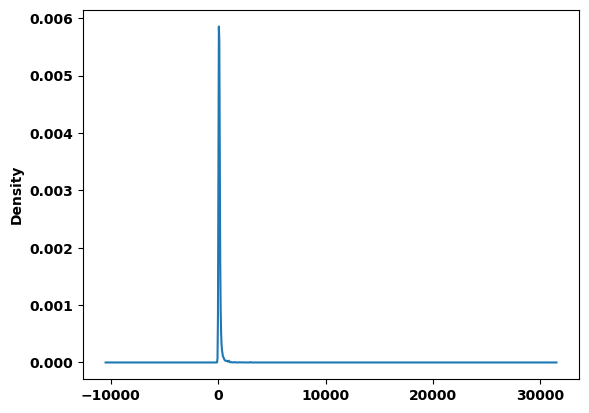

In [38]:
listings.price.plot.kde()

- Revisamos los máximos

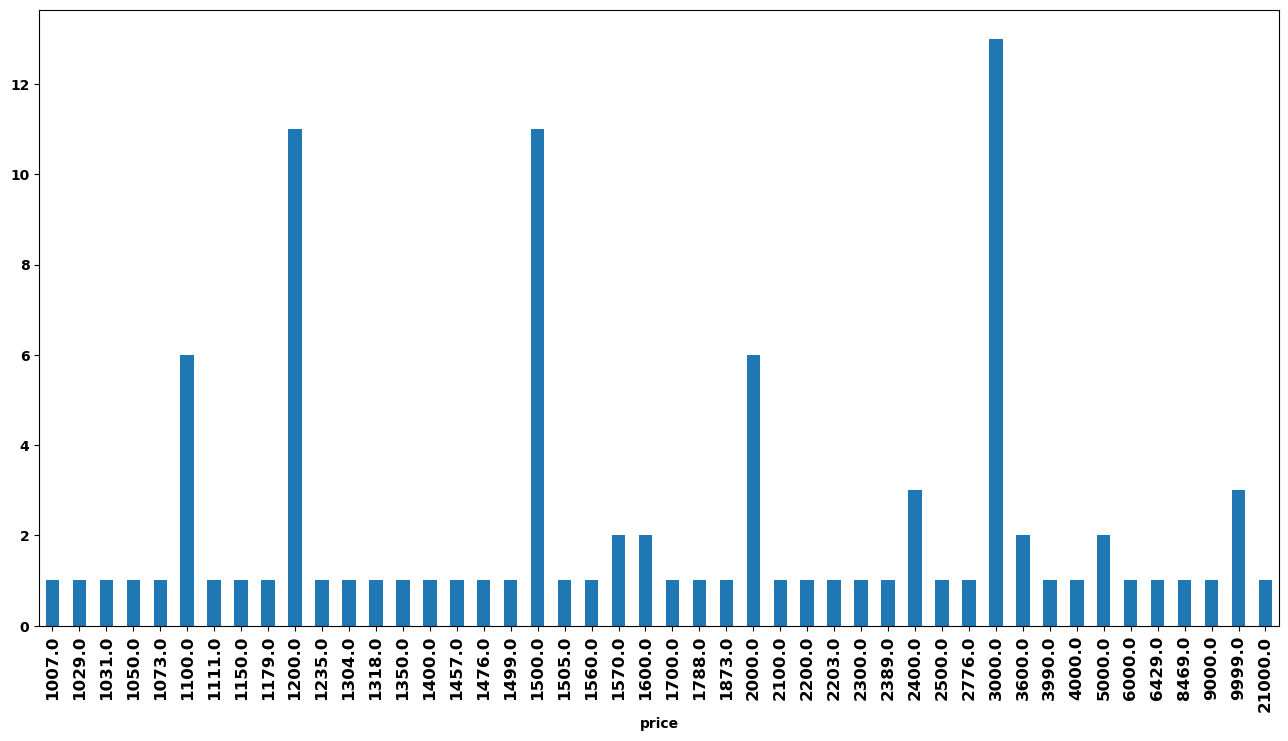

In [39]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price>1000].value_counts().sort_index().plot.bar()
plt.xticks(size=12);

- Revisamos los mínimos

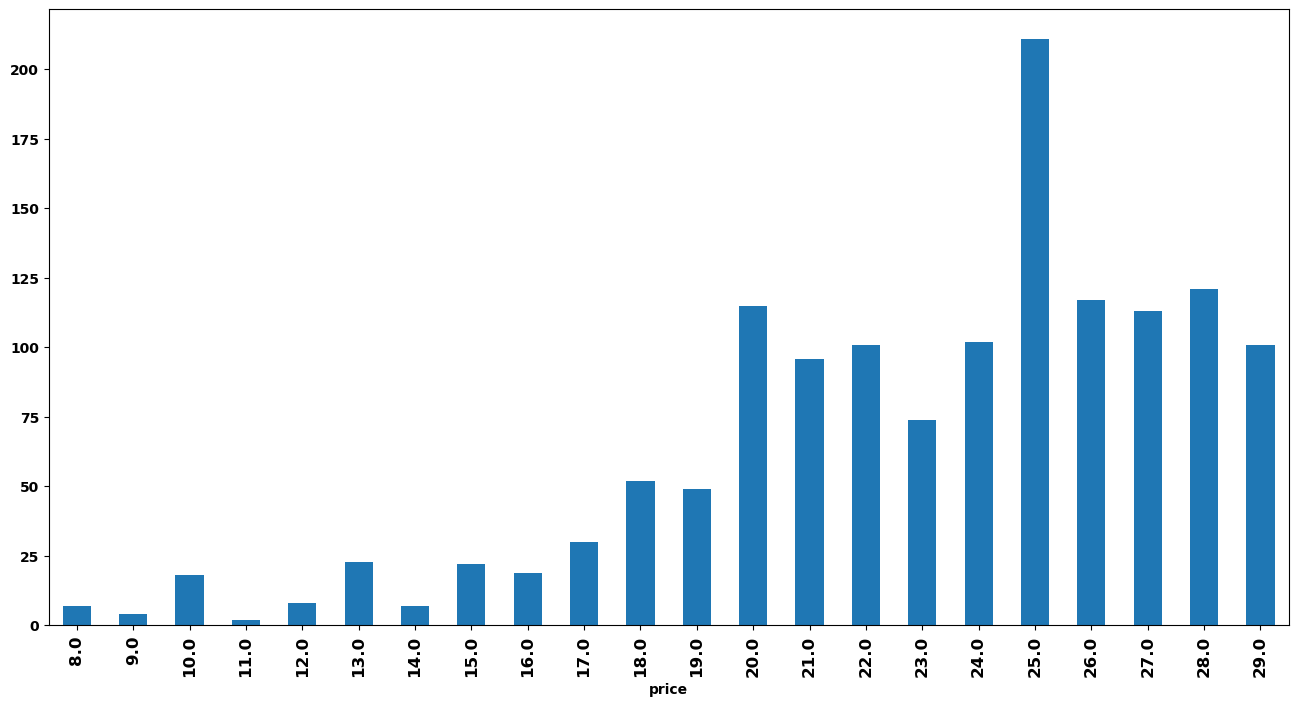

In [40]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price<30].value_counts().sort_index().plot.bar()
plt.xticks(size=12);

- Descartamos los inmuebles que se alquilen por debajo de 20€ la noche

In [41]:
listings = listings.loc[listings.price>19]


**Analisis del numero de habitaciones**

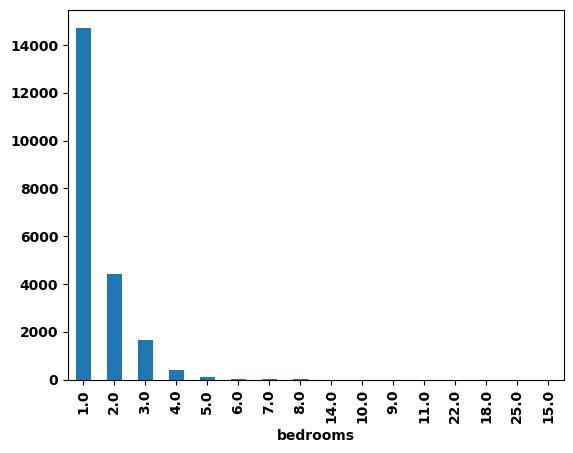

In [42]:
listings.bedrooms.value_counts().sort_values(ascending=False).plot.bar();

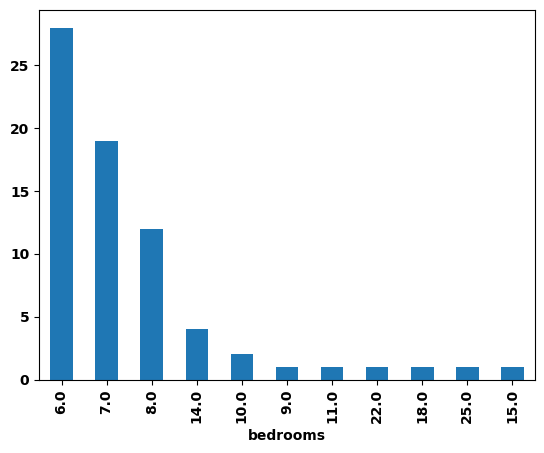

In [43]:
listings.loc[listings.bedrooms > 5].bedrooms.value_counts().sort_values(ascending=False).plot.bar();

**Analisis del numero de baños**

<Axes: xlabel='bathrooms'>

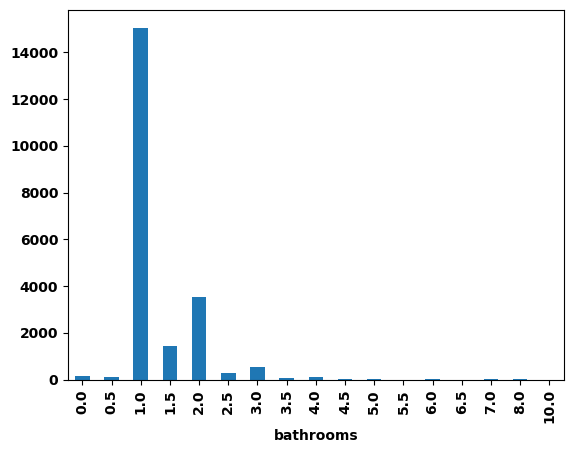

In [44]:
listings.bathrooms.value_counts().sort_index().plot.bar()

### Tabla listings detalle

In [45]:
pd.options.display.max_columns = None
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,6369,https://www.airbnb.com/rooms/6369,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,NaN,None,https://a0.muscache.com/pictures/683224/4cc318...,13660,https://www.airbnb.com/users/show/13660,Simon,2009-04-16,"Madrid, Spain","Gay couple, heterofriendly, enjoy having guest...",within an hour,100%,78%,t,https://a0.muscache.com/im/pictures/user/79a63...,https://a0.muscache.com/im/pictures/user/79a63...,Hispanoamérica,1.0,1.0,"['email', 'phone']",t,t,None,Hispanoamérica,Chamartín,40.45724,-3.67688,Private room in rental unit,Private room,2,NaN,1 private bath,NaN,1.0,[],$85.00,5,1125,3,5,1125,1125,5.0,1125.0,NaN,t,8,11,11,22,2023-12-15,106,4,0,2010-03-14,2023-10-16,4.88,4.91,4.84,4.78,4.86,4.84,4.86,None,f,1,0,1,0,0.63
1,1,21853,https://www.airbnb.com/rooms/21853,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,NaN,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,https://www.airbnb.com/users/show/83531,Abdel,2010-02-21,"Madrid, Spain",EN-ES-FR\r\nEN\r\nHi everybody: I'm Abdel. I'm...,None,None,0%,f,https://a0.muscache.com/im/users/83531/profile...,https://a0.muscache.com/im/users/83531/profile...,Aluche,2.0,2.0,"['email', 'phone']",t,t,"Madrid, Spain",Cármenes,Latina,40.40381,-3.74130,Private room in rental unit,Private room,1,NaN,1 bath,NaN,1.0,[],$31.00,4,40,4,4,40,40,4.0,40.0,NaN,t,0,0,0,135,2023-12-15,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.30
2,2,24805,https://www.airbnb.com/rooms/24805,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,NaN,"The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,346366726,https://www.airbnb.com/users/show/346366726,Alvaro,2020-05-15,None,None,None,None,None,f,https://a0.muscache.com/im/pictures/user/d3167...,https://a0.muscache.com/im/pictures/user/d3167...,None,1.0,1.0,"['email', 'phone']",t,t,"Madrid, Spain",Universidad,Centro,40.42183,-3.70529,Entire rental unit,Entire home/apt,3,NaN,1 bath,NaN,1.0,[],$94.00,5,1125,5,5,1125,1125,5.0,1125.0,NaN,t,18,48,78,168,2023-12-15,33,8,0,2014-11-29,2023-11-06,4.91,4.91,4.85,5.00,4.97,5.00,4.76,None,f,1,1,0,0,0.30
3,3,26825,https://www.airbnb.com/rooms/26825,20231215032748,2023-12-15,city scrape,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,NaN,"Es un barrio muy tranquilo, en una zona de Mad...",https://a0.muscache.com/pictures/149358/218d5b...,114340,https://www.airbnb.com/users/show/114340,Maria,2010-04-27,"Madrid, Spain","I like Fine art, Photography, Cinema, travel a...",a few days

In [63]:
listings.columns

Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365', 'bedrooms',
       'bathrooms'],
      dtype='object')

In [64]:
listings_det.columns

Index(['index', 'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_

#### Variables y data types

- Seleciconamos las variables que nos interesan para el proyecto

In [46]:
to_include = ["id","description","host_is_superhost","accommodates", "bathrooms", "bedrooms", "beds", 
             "number_of_reviews", "review_scores_rating", "review_scores_communication", 
             "review_scores_location"]

listings_det = listings_det.loc[:, to_include]


- Analisis de los tipos de variables. 

In [47]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           25543 non-null  int64  
 1   description                  0 non-null      float64
 2   host_is_superhost            25363 non-null  object 
 3   accommodates                 25543 non-null  int64  
 4   bathrooms                    0 non-null      float64
 5   bedrooms                     0 non-null      float64
 6   beds                         25238 non-null  float64
 7   number_of_reviews            25543 non-null  int64  
 8   review_scores_rating         20216 non-null  float64
 9   review_scores_communication  20215 non-null  float64
 10  review_scores_location       20212 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 2.1+ MB


In [48]:
listings_det["host_is_superhost"] = listings_det["host_is_superhost"].astype("category")

In [49]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           25543 non-null  int64   
 1   description                  0 non-null      float64 
 2   host_is_superhost            25363 non-null  category
 3   accommodates                 25543 non-null  int64   
 4   bathrooms                    0 non-null      float64 
 5   bedrooms                     0 non-null      float64 
 6   beds                         25238 non-null  float64 
 7   number_of_reviews            25543 non-null  int64   
 8   review_scores_rating         20216 non-null  float64 
 9   review_scores_communication  20215 non-null  float64 
 10  review_scores_location       20212 non-null  float64 
dtypes: category(1), float64(7), int64(3)
memory usage: 2.0 MB


#### Analisis de nulos

In [50]:
listings_det.isna().sum()

id                                 0
description                    25543
host_is_superhost                180
accommodates                       0
bathrooms                      25543
bedrooms                       25543
beds                             305
number_of_reviews                  0
review_scores_rating            5327
review_scores_communication     5328
review_scores_location          5331
dtype: int64

- En el dataset listings detallado no contiene información acerca del numero de baños y de habitaciones. Por ello hemos extraido esta informacion de la variable name del dataset de lintings. 
- La variable descripción está vacía y no aporta información

- Intentamos imputar los nulos en el numero de camas con la variable accomodates que utilizamos como proxy, que indica el numero de personas que se aceptan en la vivienda. 

In [51]:
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1.0,3668,7487,553,730,21,24,2,1,0,5,0,0,0,0,0,1
2.0,151,1196,1651,3469,147,152,3,10,0,1,0,0,1,0,0,1
3.0,32,80,277,1218,565,888,35,32,0,2,0,0,0,0,0,0
4.0,38,39,22,282,276,654,126,187,8,4,0,1,0,0,0,0
5.0,10,5,3,25,68,181,91,120,22,43,1,4,0,0,0,0
6.0,21,4,4,5,7,65,18,86,13,34,7,15,0,2,0,0
7.0,2,0,0,1,1,7,10,22,17,20,3,11,1,4,0,0
8.0,11,8,1,1,1,4,0,20,6,20,2,10,3,2,0,1
9.0,0,1,0,0,0,0,0,3,5,10,1,4,0,2,1,3


- Si la vivienda acomoda a 1 o 2 personas se suele corresponder con que el piso tenga una cama 
- Si la vivienda acomoda a 3 o 4 personas el valor que suele corresponder es que el piso tenga 2 camas
- Si la vivienda acomoda a 5 o 6 personas el valor mas frecuente es que el piso tenga 3 camas
- Si el piso acomoda a mas de 6 personas vamos a estimar que el piso tiene 4 camas

In [52]:
listings_det.beds.value_counts(dropna=False)

beds
1.0     12492
2.0      6782
3.0      3129
4.0      1637
5.0       573
NaN       305
6.0       281
7.0        99
8.0        90
10.0       59
12.0       31
9.0        30
11.0        9
14.0        8
20.0        6
13.0        5
16.0        3
17.0        1
15.0        1
40.0        1
30.0        1
Name: count, dtype: int64

In [53]:
def imputar_nulos(registro): 
    #lista de condiciones
    condiciones =[(registro.accommodates <=2),
                  (registro.accommodates>2) & (registro.accommodates<=4), 
                 (registro.accommodates >4)&(registro.accommodates<=6), 
                 (registro.accommodates >6)]
    #lista de resultados
    resultados = [1, 2, 3, 4]
    
    return (np.select(condiciones, resultados, default= -999))

In [54]:
listings_det.loc[listings_det.beds.isna(), "beds"] = listings_det.loc[listings_det.beds.isna()].apply(imputar_nulos, axis=1).astype(int)

In [55]:
listings_det.beds.value_counts()

beds
1.0     12730
2.0      6834
3.0      3140
4.0      1641
5.0       573
6.0       281
7.0        99
8.0        90
10.0       59
12.0       31
9.0        30
11.0        9
14.0        8
20.0        6
13.0        5
16.0        3
17.0        1
15.0        1
40.0        1
30.0        1
Name: count, dtype: int64

#### Analisis de duplicados

In [56]:
listings_det.duplicated().sum()

0

#### Analisis de variables categoricas

In [57]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           25543 non-null  int64   
 1   description                  0 non-null      float64 
 2   host_is_superhost            25363 non-null  category
 3   accommodates                 25543 non-null  int64   
 4   bathrooms                    0 non-null      float64 
 5   bedrooms                     0 non-null      float64 
 6   beds                         25543 non-null  float64 
 7   number_of_reviews            25543 non-null  int64   
 8   review_scores_rating         20216 non-null  float64 
 9   review_scores_communication  20215 non-null  float64 
 10  review_scores_location       20212 non-null  float64 
dtypes: category(1), float64(7), int64(3)
memory usage: 2.0 MB


In [58]:
listings_det.host_is_superhost.value_counts()

host_is_superhost
f    19676
t     5687
Name: count, dtype: int64

#### Analisis de variables numéricas

In [59]:
listings_det.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
id,25543.0,4.159907e+17,4.324774e+17,6369.0,31148623.50,53976090.00,8.698655e+17,1.046255e+18
description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,25543.0,3.126727e+00,1.920497e+00,1.0,2.00,2.00,4.000000e+00,1.600000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beds,25543.0,1.962338e+00,1.450671e+00,1.0,1.00,2.00,2.000000e+00,4.000000e+01
number_of_reviews,25543.0,4.286904e+01,8.104807e+01,0.0,1.00,10.00,4.600000e+01,9.940000e+02
review_scores_rating,20216.0,4.640384e+00,4.836087e-01,0.0,4.53,4.75,4.920000e+00,5.000000e+00
review_scores_communication,20215.0,4.759503e+00,4.435415e-01,1.0,4.72,4.89,5.000000e+00,5.000000e+00
review_scores_location,20212.0,4.746825e+00,3.948586e-01,1.0,4.67,4.88,4.990000e+00,5.000000e+00


- El numero maximo de camas es 40 y resulta extraño pero hemos comprobado que es para hoteles, por lo que tiene sentido, pero no los vamos aincluir en nuestroa analisis. 



In [60]:
listings_det.drop(columns= ["description", "bathrooms", "bedrooms"], inplace=True)

In [61]:
listings_det.head()

,id,host_is_superhost,accommodates,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,t,2,1.0,106,4.88,4.86,4.84
1,21853,f,1,1.0,33,4.58,4.82,4.21
2,24805,f,3,1.0,33,4.91,4.97,5.00
3,26825,t,1,1.0,196,4.72,4.72,4.73
4,30320,f,2,2.0,172,4.63,4.78,4.90


## Tablon Analítico

- Tablas disponibles: 
    1) listings
    2) listings_det
    3) precio_m2

La tabla principal es listings, ya que lo que hace listings_det es aportar detalles adicionales. Por tanto la tabla que manda en la integración de datos es Listings, y las cruzaremos por la variable id. 

La tabla precio_m2, comparte el campo del distrito (neighbourhood_group), aunque para integrarla al tablón analítico debemos revisar primero si los literales de los distritos son exactamente iguales en ambas tablas. 



In [62]:
for cada in [listings, listings_det]:
    print(cada.shape)

(21387, 14)
(25543, 8)


In [63]:
df = pd.merge(left=listings, right=listings_det, how="left", on="id")


In [64]:
df.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,bedrooms,bathrooms,host_is_superhost,accommodates,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,85.0,5,1,22,1.0,1.0,t,2,1.0,106,4.88,4.86,4.84
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.41476,-3.70418,Entire home/apt,65.0,5,3,0,1.0,1.0,f,2,2.0,172,4.63,4.78,4.90
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,2,135,1.0,1.0,f,1,1.0,33,4.58,4.82,4.21
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,94.0,5,1,168,6.0,1.0,f,3,1.0,33,4.91,4.97,5.00
4,26825,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29.0,3,1,295,1.0,1.5,t,1,1.0,196,4.72,4.72,4.73


In [65]:
df.neighbourhood_group.unique().categories

Index(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'],
      dtype='object')

In [66]:
precio_m2.distrito.unique()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral', 'Hortaleza', 'Latina',
       'Moncloa', 'Moratalaz', 'Puente de Vallecas', 'Retiro',
       'Salamanca', 'San Blas', 'Tetuán', 'Usera', 'Vicálvaro',
       'Villa de Vallecas', 'Villaverde'], dtype=object)

In [67]:
precio_m2["distrito"] = precio_m2.distrito.map({"Fuencarral":"Fuencarral - El Pardo", 
                        "Moncloa":"Moncloa - Aravaca",
                        "San Blas":"San Blas - Canillejas"})\
                    .fillna(precio_m2.distrito)


In [68]:
precio_m2.distrito.unique()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'], dtype=object)

In [69]:
df.shape

(21387, 21)

In [70]:
precio_m2.shape

(21, 2)

In [71]:
df = pd.merge(left=df, right=precio_m2, how="left", left_on="neighbourhood_group", right_on="distrito")

In [72]:
df.drop(columns="distrito", inplace=True)

## Guardar tabla en la base de datos

- Guardamos nuestra tabla final en la base de datos airbnb.db

In [74]:
import sqlalchemy as sa

con = sa.create_engine("sqlite:///Datos2023/airbnb.db")

df.to_sql("df", con=con, if_exists="replace")

21387

In [75]:
from sqlalchemy import inspect

ins = inspect(con)
tablas = ins.get_table_names()
tablas

['df', 'df_analisis', 'listings', 'listings_det']